In [25]:
import os
import jax
import jax.numpy as jnp
import numpy as np
import jax.tree_util as jtu
import numpy as np
import optax
import orbax
import scanpy as sc
from omegaconf import DictConfig, OmegaConf
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, otfm, genot
from ott.neural.networks.layers import time_encoder
from ott.neural.networks.velocity_field import VelocityField
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm
from functools import partial
import sys
from typing import Literal, Optional, Dict, Tuple
import pandas as pd
import datetime
from sklearn.metrics import r2_score
import seaborn as sns

from ot_pert.metrics import compute_mean_metrics, compute_metrics, compute_metrics_fast
from ot_pert.nets.nets import CondVelocityField
from ot_pert.utils import ConditionalLoader

In [26]:
def reconstruct_data(embedding: np.ndarray, projection_matrix: np.ndarray, mean_to_add: np.ndarray) -> np.ndarray:
    return np.matmul(embedding, projection_matrix.T) + mean_to_add

def get_mask(x, y, var_names):
    return x[:, [gene in y for gene in var_names]]

def data_match_fn(
        src_lin: Optional[jnp.ndarray],
        tgt_lin: Optional[jnp.ndarray],
        src_quad: Optional[jnp.ndarray],
        tgt_quad: Optional[jnp.ndarray],
        *,
        typ: Literal["lin", "quad", "fused"],
        epsilon: float = 1e-2,
        tau_a: float = 1.0,
        tau_b: float = 1.0,
    ) -> jnp.ndarray:
        if typ == "lin":
            return solver_utils.match_linear(
                x=src_lin, y=tgt_lin, scale_cost="mean", epsilon=epsilon, tau_a=tau_a, tau_b=tau_b
            )
        if typ == "quad":
            return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
        if typ == "fused":
            return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin)
        raise NotImplementedError(f"Unknown type: {typ}.")

def compute_r_squared(x: np.ndarray, y: np.ndarray) -> float:
    return r2_score(np.mean(x, axis=0), np.mean(y, axis=0))

def load_data(adata, cfg, *, return_dl: bool):
    """Loads data and preprocesses it based on configuration."""
    dls = []
    data_source = {}
    data_target = {}
    data_source_decoded = {}
    data_target_decoded = {}
    data_conditions = {}
    for cond in adata.obs["condition"].cat.categories:
        if not cond.endswith('_NT'):
            src_str_unique = list(adata[adata.obs["condition"] == cond].obs["cell_type"].unique())
            assert len(src_str_unique) == 1
            src_str = src_str_unique[0] + "_NT"
            source = adata[adata.obs["condition"] == src_str].obsm[cfg['dataset']['obsm_key_data']]
            source_decoded = adata[adata.obs["condition"] == src_str].X.A
            target = adata[adata.obs["condition"] == cond].obsm[cfg['dataset']['obsm_key_data']]
            target_decoded = adata[adata.obs["condition"] == cond].X.A
            conds = adata[adata.obs["condition"] == cond].obsm[cfg['dataset']['obsm_key_cond']]
            assert np.all(np.all(conds == conds[0], axis=1))
            conds = np.tile(conds[0], (len(source), 1))
            if return_dl:
                dls.append(
                    DataLoader(
                        datasets.OTDataset(
                            datasets.OTData(
                                lin=source,
                                condition=conds,
                            ),
                            datasets.OTData(lin=target),
                        ),
                        batch_size=cfg['training']['batch_size'],
                        shuffle=True,
                    )
                )
            else:
                data_source[cond] = source
                data_target[cond] = target
                data_source_decoded[cond] = source_decoded
                data_target_decoded[cond] = target_decoded
                data_conditions[cond] = conds
    if return_dl:
        return ConditionalLoader(dls, seed=0)

    deg_dict = {k: v for k, v in adata.uns["rank_genes_groups_cov_all"].items() if k in data_conditions.keys()}

    return {
        "source": data_source,
        "target": data_target,
        "source_decoded": data_source_decoded,
        "target_decoded": data_target_decoded,
        "conditions": data_conditions,
        "deg_dict": deg_dict,
    }

def eval_step(cfg, model, data, log_metrics, reconstruct_data_fn, comp_metrics_fn, mask_fn):
    metrics_per_set = []
    for k, dat in data.items():
        if k == "test":
            n_samples = cfg['training']['n_test_samples']
        if k == "train":
            n_samples = cfg['training']['n_train_samples']
        if k == "ood":
            n_samples = cfg['training']['n_ood_samples']

        if n_samples != 0:
            if n_samples > 0:
                idcs = np.random.choice(list(list(dat.values())[0]), n_samples)
                dat_source = {k: v for k, v in dat["source"].items() if k in idcs}
                dat_target = {k: v for k, v in dat["target"].items() if k in idcs}
                dat_conditions = {k: v for k, v in dat["conditions"].items() if k in idcs}
                dat_deg_dict = {k: v for k, v in dat["deg_dict"].items() if k in idcs}
                data_source_decoded = {k: v for k, v in dat["source_decoded"].items() if k in idcs}
                dat_target_decoded = {k: v for k, v in dat["target_decoded"].items() if k in idcs}
            else:
                dat_source = dat["source"]
                dat_target = dat["target"]
                dat_conditions = dat["conditions"]
                dat_deg_dict = dat["deg_dict"]
                data_source_decoded = dat["source_decoded"]
                dat_target_decoded = dat["target_decoded"]

            prediction = jtu.tree_map(model.transport, dat_source, dat_conditions)
            metrics = jtu.tree_map(comp_metrics_fn, dat_target, prediction)

            predicted_target = jax.tree_util.tree_map(model.transport, dat_source, dat_conditions)
            r2 = jax.tree_util.tree_map(compute_r_squared, predicted_target, dat_target)
            r2_baseline = jax.tree_util.tree_map(compute_r_squared, dat_source, dat_target)
            # ood_metrics = jax.tree_util.tree_map(compute_metrics, ood_data_target, predicted_target_ood)
            # mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

            predicted_target_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target)
            r2_decoded = jax.tree_util.tree_map(compute_r_squared, predicted_target_decoded, dat_target_decoded)
            r2_baseline_decoded = jax.tree_util.tree_map(compute_r_squared, data_source_decoded, dat_target_decoded)

            metrics_dict = {}
            metrics_dict['gene'] = [k.split('_')[1] for k in r2.keys()]
            metrics_dict['test_r2'] = r2.values()
            metrics_dict['test_r2_decoded'] = r2_decoded.values()
            metrics_dict['test_r2_baseline'] = r2_baseline.values()
            metrics_dict['test_r2_baseline_decoded'] = r2_baseline_decoded.values()
            metrics_dict['data'] = k
            #mean_metrics = compute_mean_metrics(metrics, prefix=f"{k}_")
            #log_metrics.update(mean_metrics)

            # prediction_decoded = jtu.tree_map(reconstruct_data_fn, prediction)
            # metrics_decoded = jtu.tree_map(comp_metrics_fn, dat_target_decoded, prediction_decoded)
            #mean_metrics_decoded = compute_mean_metrics(metrics_decoded, prefix=f"decoded_{k}_")
            #log_metrics.update(mean_metrics_decoded)
            metrics_per_set.append(pd.DataFrame(metrics_dict))
    metrics_per_set = pd.concat(metrics_per_set, ignore_index=True)
    return metrics_per_set

            # test_dict = {}
#         test_dict['gene'] = [k.split('_')[1] for k in test_r2.keys()]
#         test_dict['test_r2'] = test_r2.values()
#         test_dict['test_r2_decoded'] = test_r2_decoded.values()
#         test_dict['test_r2_baseline'] = test_r2_baseline.values()
#         test_dict['test_r2_baseline_decoded'] = test_r2_baseline_decoded.values()
#         test_dict['iter'] = it

#         ood_dict = {}
#         ood_dict['gene'] = [k.split('_')[1] for k in ood_r2.keys()]
#         ood_dict['ood_r2'] = ood_r2.values()
#         ood_dict['ood_r2_decoded'] = ood_r2_decoded.values()
#         ood_dict['ood_r2_baseline'] = ood_r2_baseline.values()
#         ood_dict['ood_r2_baseline_decoded'] = ood_r2_baseline_decoded.values()
#         ood_dict['iter'] = it
        
#         df_test.append(pd.DataFrame(test_dict))
#         df_ood.append(pd.DataFrame(ood_dict))

            # prediction_decoded_deg = jtu.tree_map(mask_fn, prediction_decoded, dat_deg_dict)
            # target_decoded_deg = jax.tree_util.tree_map(mask_fn, dat_target_decoded, dat_deg_dict)
            # metrics_deg = jtu.tree_map(comp_metrics_fn, target_decoded_deg, prediction_decoded_deg)
            # mean_metrics_deg = compute_mean_metrics(metrics_deg, prefix=f"deg_{k}_")
            #log_metrics.update(mean_metrics_deg)

    #wandb.log(log_metrics)

def prepare_data(
    batch: Dict[str, jnp.ndarray],
) -> Tuple[
    Tuple[jnp.ndarray, Optional[jnp.ndarray], jnp.ndarray],
    Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray], Optional[jnp.ndarray]],
]:
    src_lin, src_quad = batch.get("src_lin"), batch.get("src_quad")
    tgt_lin, tgt_quad = batch.get("tgt_lin"), batch.get("tgt_quad")

    if src_quad is None and tgt_quad is None:  # lin
        src, tgt = src_lin, tgt_lin
        arrs = src_lin, tgt_lin
    elif src_lin is None and tgt_lin is None:  # quad
        src, tgt = src_quad, tgt_quad
        arrs = src_quad, tgt_quad
    elif all(arr is not None for arr in (src_lin, tgt_lin, src_quad, tgt_quad)):  # fused quad
        src = jnp.concatenate([src_lin, src_quad], axis=1)
        tgt = jnp.concatenate([tgt_lin, tgt_quad], axis=1)
        arrs = src_quad, tgt_quad, src_lin, tgt_lin
    else:
        raise RuntimeError("Cannot infer OT problem type from data.")

    return (src, batch.get("src_condition"), tgt), arrs

In [3]:
cfg = {
    'dataset': {
        'dataset_path': '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets/r2',
        'pathway': 'IFNG',
        'cell_type': 'BXPC3',
        'obsm_key_data': 'X_pca',
        'obsm_key_cond': 'cond_emb'
        
    },
    'training': {
        'batch_size': 1024,
        'valid_freq': 10,
        'num_iterations': 10000,
        'out_dir': '/lustre/groups/ml01/workspace/ot_perturbation/data/satija/datasets',
        'n_train_samples': 0,
        'n_test_samples': 10,
        'n_ood_samples': -1,
        'fast_metrics': True
    },
    'model': {
        'hidden_dims': [1024, 1024, 1024],
        'time_dims': [512, 512],
        'output_dims': [1024, 1024, 1024],
        'condition_dims': [1024, 1024, 512],
        'time_n_freqs': 1024,
        'flow_noise': 0.1,
        'learning_rate': 0.0001,
        'multi_steps': 20,
        'epsilon': 0.01,
        'tau_a': 1.0,
        'tau_b': 1.0,
        'dropout_rate': 0.0
    },
    'conf': {
        'run': {
            'dir': 'checkpoint_dir'
        }
    }
}

In [4]:
adata_train_path = os.path.join(cfg['dataset']['dataset_path'], 'adata_train_' + cfg['dataset']['pathway'] + '_' + cfg['dataset']['cell_type'] + '.h5ad')
adata_test_path = os.path.join(cfg['dataset']['dataset_path'], 'adata_test_' + cfg['dataset']['pathway'] + '_' + cfg['dataset']['cell_type'] + '.h5ad')
adata_ood_path = os.path.join(cfg['dataset']['dataset_path'], 'adata_ood_' + cfg['dataset']['pathway'] + '_' + cfg['dataset']['cell_type'] + '.h5ad')

In [5]:
adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)

In [6]:
comp_metrics_fn = compute_metrics_fast if cfg['training']['fast_metrics'] else compute_metrics
mask_fn = partial(get_mask, var_names=adata_train.var_names)

In [7]:
dl = load_data(adata_train, cfg, return_dl=True)

In [8]:
train_data = load_data(adata_train, cfg, return_dl=False) if cfg['training']['n_train_samples'] != 0 else {}
test_data = load_data(adata_test, cfg, return_dl=False) if cfg['training']['n_test_samples'] != 0 else {}
ood_data = load_data(adata_ood, cfg, return_dl=False) if cfg['training']['n_ood_samples'] != 0 else {}

In [9]:
reconstruct_data_fn = partial(
    reconstruct_data, projection_matrix=adata_train.varm["PCs"], mean_to_add=adata_train.varm["X_train_mean"].T
)

In [10]:
batch = next(dl)
output_dim = batch["tgt_lin"].shape[1]
condition_dim = batch["src_condition"].shape[1]

In [11]:
vf = CondVelocityField(
    hidden_dims=cfg['model']['hidden_dims'],
    time_dims=cfg['model']['time_dims'],
    output_dims=cfg['model']['output_dims'] + [output_dim],
    condition_dims=cfg['model']['condition_dims'],
    dropout_rate=cfg['model']['dropout_rate'],
    time_encoder=partial(time_encoder.cyclical_time_encoder, n_freqs=cfg['model']['time_n_freqs']),
)

In [12]:
# vf = VelocityField(
#     hidden_dims=cfg['model']['hidden_dims'],
#     time_dims=cfg['model']['time_dims'],
#     output_dims=cfg['model']['output_dims'] + [target_dim],
#     condition_dims=cfg['model']['condition_dims'],
#     time_encoder=partial(time_encoder.cyclical_time_encoder, n_freqs=cfg['model']['time_n_freqs']),
# )

In [13]:
# model = otfm.OTFlowMatching(
#     vf,
#     flow=dynamics.ConstantNoiseFlow(cfg['model']['flow_noise']),
#     match_fn=jax.jit(
#         partial(
#             data_match_fn,
#             typ="lin",
#             src_quad=None,
#             tgt_quad=None,
#             epsilon=cfg['model']['epsilon'],
#             tau_a=cfg['model']['tau_a'],
#             tau_b=cfg['model']['tau_b'],
#         )
#     ),
#     condition_dim=condition_dim,
#     rng=jax.random.PRNGKey(13),
#     optimizer=optax.MultiSteps(optax.adam(learning_rate=cfg['model']['learning_rate']), cfg['model']['multi_steps']),
# )

In [16]:
model = genot.GENOT(
    vf,
    flow=dynamics.ConstantNoiseFlow(0.0),
    data_match_fn=jax.jit(
        partial(
            data_match_fn,
            typ="lin",
            src_quad=None,
            tgt_quad=None,
            epsilon=cfg['model']['epsilon'],
            tau_a=cfg['model']['tau_a'],
            tau_b=cfg['model']['tau_b'],
        )
    ),
    source_dim=output_dim,
    target_dim=output_dim,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20), )

In [27]:
training_logs = {"loss": []}

df_test = []
df_ood = []
rng = jax.random.PRNGKey(0)
for it in tqdm(range(cfg['training']['num_iterations'])):
    batch = next(iter(dl))
    batch = jtu.tree_map(jnp.asarray, batch)
    rng = jax.random.split(rng, 5)
    rng, rng_resample, rng_noise, rng_time, rng_step_fn = rng

    batch = jtu.tree_map(jnp.asarray, batch)
    (src, src_cond, tgt), matching_data = prepare_data(batch)

    n = src.shape[0]
    time = model.time_sampler(rng_time, n * model.n_samples_per_src)
    latent = model.latent_noise_fn(rng_noise, (n, model.n_samples_per_src))

    tmat = model.data_match_fn(*matching_data)  # (n, m)
    src_ixs, tgt_ixs = solver_utils.sample_conditional(  # (n, k), (m, k)
        rng_resample,
        tmat,
        k=model.n_samples_per_src,
    )

    src, tgt = src[src_ixs], tgt[tgt_ixs]  # (n, k, ...),  # (m, k, ...)
    if src_cond is not None:
        src_cond = src_cond[src_ixs]

    if model.latent_match_fn is not None:
        src, src_cond, tgt = model._match_latent(rng, src, src_cond, latent, tgt)

    src = src.reshape(-1, *src.shape[2:])  # (n * k, ...)
    tgt = tgt.reshape(-1, *tgt.shape[2:])  # (m * k, ...)
    latent = latent.reshape(-1, *latent.shape[2:])
    if src_cond is not None:
        src_cond = src_cond.reshape(-1, *src_cond.shape[2:])

    loss, model.vf_state = model.step_fn(rng_step_fn, model.vf_state, time, src, tgt, latent, src_cond)

    training_logs["loss"].append(float(loss))
    #if ((it % cfg['training']['valid_freq'] == 0) and (it > 0)) | it == (cfg['training']['num_iterations'] -1):
    if it == (cfg['training']['num_iterations'] -1):
        print('calc metrics')
        train_loss = np.mean(training_logs["loss"][-cfg['training']['valid_freq'] :])
        log_metrics = {"train_loss": train_loss}
        metrics = eval_step(
            cfg,
            model,
            {"train": train_data, "test": test_data, "ood": ood_data},
            log_metrics,
            reconstruct_data_fn,
            comp_metrics_fn,
            mask_fn,
        )
        
# if cfg['training']['save_model']:
#     checkpointer = orbax.checkpoint.PyTreeCheckpointer()
#     checkpointer.save(os.path.join(cfg['conf']['run']['dir'], "model"), model.vf_state)

#return 1.0

        
#         idcs = np.random.choice(list(test_data_source.keys()), 20)
#         test_data_source_tmp = {k:v for k,v in test_data_source.items() if k in idcs}
#         test_data_target_tmp = {k:v for k,v in test_data_target.items() if k in idcs}
#         test_data_conditions_tmp = {k:v for k,v in test_data_conditions.items() if k in idcs}
#         #test_deg_dict_tmp = {k:v for k,v in test_deg_dict.items() if k in idcs}
#         test_data_target_decoded_tmp = {k:v for k,v in test_data_target_decoded.items() if k in idcs}
#         test_data_source_decoded_tmp = {k:v for k,v in test_data_source_decoded.items() if k in idcs}
#         test_data_source
#         valid_losses = []
#         for cond in test_data_source_tmp.keys():
#             src = test_data_source_tmp[cond]
#             tgt = test_data_target_tmp[cond]
#             src_cond = test_data_conditions_tmp[cond]
#             if model.match_fn is not None:
#                 tmat = model.match_fn(src, tgt)
#                 src_ixs, tgt_ixs = solver_utils.sample_joint(rng_resample, tmat)
#                 src, tgt = src[src_ixs], tgt[tgt_ixs]
#                 src_cond = None if src_cond is None else src_cond[src_ixs]
#             _, valid_loss = model.step_fn(
#                 rng,
#                 model.vf_state,
#                 src,
#                 tgt,
#                 src_cond,
#             )
#             valid_losses.append(valid_loss)

#         predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source_tmp, test_data_conditions_tmp)
#         test_r2 = jax.tree_util.tree_map(compute_r_squared, predicted_target_test, test_data_target_tmp)
#         test_r2_baseline = jax.tree_util.tree_map(compute_r_squared, test_data_source_tmp, test_data_target_tmp)
#         #test_metrics = jax.tree_util.tree_map(compute_metrics, test_data_target_tmp, predicted_target_test)
#         #mean_test_metrics = compute_mean_metrics(test_metrics, prefix="test_")
#         test_condition = test_data_conditions_tmp

#         predicted_target_test_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_test)
#         test_r2_decoded = jax.tree_util.tree_map(compute_r_squared, predicted_target_test_decoded, test_data_target_decoded_tmp)
#         test_r2_baseline_decoded = jax.tree_util.tree_map(compute_r_squared, test_data_source_decoded_tmp, test_data_target_decoded_tmp)
#         # test_metrics_decoded = jax.tree_util.tree_map(
#         #     compute_metrics, test_data_target_decoded_tmp, predicted_target_test_decoded
#         # )
#         # mean_test_metrics_decoded = compute_mean_metrics(test_metrics_decoded, prefix="decoded_test_")

#         # test_deg_target_decoded_predicted = jax.tree_util.tree_map(
#         #     get_mask, predicted_target_test_decoded, test_deg_dict_tmp
#         # )
#         # test_deg_target_decoded = jax.tree_util.tree_map(get_mask, test_data_target_decoded_tmp, test_deg_dict_tmp)
#         # deg_test_metrics_encoded = jax.tree_util.tree_map(
#         #     compute_metrics, test_deg_target_decoded, test_deg_target_decoded_predicted
#         # )
#         # deg_mean_test_metrics_encoded = compute_mean_metrics(deg_test_metrics_encoded, prefix="deg_test_")

#         predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source, ood_data_conditions)
#         ood_r2 = jax.tree_util.tree_map(compute_r_squared, predicted_target_ood, ood_data_target)
#         ood_r2_baseline = jax.tree_util.tree_map(compute_r_squared, ood_data_source, ood_data_target)
#         # ood_metrics = jax.tree_util.tree_map(compute_metrics, ood_data_target, predicted_target_ood)
#         # mean_ood_metrics = compute_mean_metrics(ood_metrics, prefix="ood_")

#         predicted_target_ood_decoded = jax.tree_util.tree_map(reconstruct_data_fn, predicted_target_ood)
#         ood_r2_decoded = jax.tree_util.tree_map(compute_r_squared, predicted_target_ood_decoded, ood_data_target_decoded)
#         ood_r2_baseline_decoded = jax.tree_util.tree_map(compute_r_squared, ood_data_source_decoded, ood_data_target_decoded)
#         # ood_metrics_decoded = jax.tree_util.tree_map(
#         #     compute_metrics, ood_data_target_decoded, predicted_target_ood_decoded
#         # )
#         # mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

#         # ood_deg_target_decoded_predicted = jax.tree_util.tree_map(
#         #     get_mask, predicted_target_ood_decoded, ood_deg_dict
#         # )
#         # ood_deg_target_decoded = jax.tree_util.tree_map(get_mask, ood_data_target_decoded, ood_deg_dict)
#         # deg_ood_metrics_encoded = jax.tree_util.tree_map(
#         #     compute_metrics, ood_deg_target_decoded, ood_deg_target_decoded_predicted
#         # )
#         # deg_mean_ood_metrics_encoded = compute_mean_metrics(deg_ood_metrics_encoded, prefix="deg_ood_")

        
#         # loss_dict = {
#         #     "train_loss": np.mean(training_logs["loss"][-cfg['training']['valid_freq'] :]),
#         #     "valid_loss": np.mean(valid_losses),
#         # }
#         # loss_dict.update(mean_test_metrics)
#         # loss_dict.update(mean_ood_metrics)
#         # loss_dict.update(mean_test_metrics_decoded)
#         # loss_dict.update(mean_ood_metrics_decoded)
#         test_dict = {}
#         test_dict['gene'] = [k.split('_')[1] for k in test_r2.keys()]
#         test_dict['test_r2'] = test_r2.values()
#         test_dict['test_r2_decoded'] = test_r2_decoded.values()
#         test_dict['test_r2_baseline'] = test_r2_baseline.values()
#         test_dict['test_r2_baseline_decoded'] = test_r2_baseline_decoded.values()
#         test_dict['iter'] = it

#         ood_dict = {}
#         ood_dict['gene'] = [k.split('_')[1] for k in ood_r2.keys()]
#         ood_dict['ood_r2'] = ood_r2.values()
#         ood_dict['ood_r2_decoded'] = ood_r2_decoded.values()
#         ood_dict['ood_r2_baseline'] = ood_r2_baseline.values()
#         ood_dict['ood_r2_baseline_decoded'] = ood_r2_baseline_decoded.values()
#         ood_dict['iter'] = it
        
#         df_test.append(pd.DataFrame(test_dict))
#         df_ood.append(pd.DataFrame(ood_dict))
    
# df_test = pd.concat(df_test, ignore_index=True)
# df_ood = pd.concat(df_ood, ignore_index=True)
# #time = datetime.datetime.now().strftime("%Y%m%d-%H%M")
# #df.to_csv('train_satija_ifng_' + time +'.csv', index=False)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 9999/10000 [25:22<00:00,  5.75it/s]

calc metrics


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [27:37<00:00,  6.03it/s]


In [28]:
metrics

,gene,test_r2,test_r2_decoded,test_r2_baseline,test_r2_baseline_decoded,data
0,BATF2,0.596586,0.985804,-7.088418,0.966609,test
1,ETV7,0.608434,0.981886,-5.206749,0.969455,test
2,GUK1,0.623787,0.982344,-3.336513,0.974198,test
3,IRF1,0.001164,0.986197,-2.572592,0.979040,test
4,IRF2,0.437322,0.978899,-10.579979,0.956061,test
5,STAT3,0.368345,0.984031,-1.706134,0.979031,test
6,TBX21,-0.512484,0.982475,-2.057413,0.979697,test
7,ATF5,0.101189,0.994955,-0.745612,0.991816,ood
8,EHF,-1.120766,0.986169,-4.447148,0.977650,ood
9,IFI16,-9.023252,0.977199,-6.177615,0.973025,ood


<Axes: >

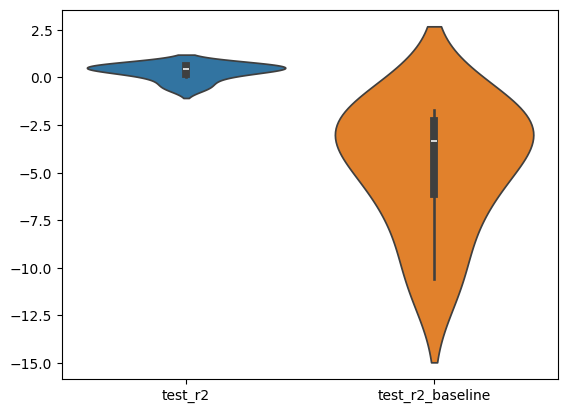

In [29]:
sns.violinplot(metrics.query('data == "test"')[['test_r2', 'test_r2_baseline']])

<Axes: >

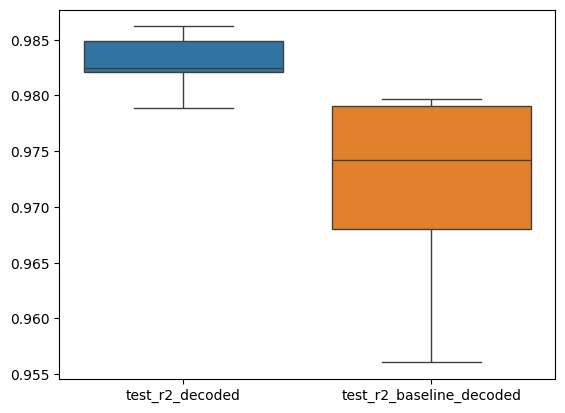

In [30]:
sns.boxplot(metrics.query('data == "test"')[['test_r2_decoded', 'test_r2_baseline_decoded']])

<Axes: >

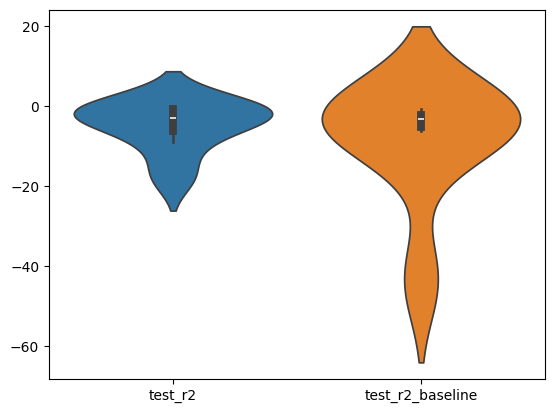

In [31]:
sns.violinplot(metrics.query('data == "ood"')[['test_r2', 'test_r2_baseline']])

<Axes: >

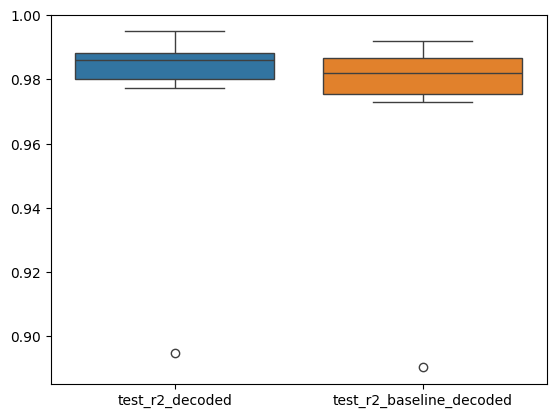

In [32]:
sns.boxplot(metrics.query('data == "ood"')[['test_r2_decoded', 'test_r2_baseline_decoded']])